In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from dython.nominal import associations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from pycaret.regression import *
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from flaml import AutoML
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix
import joblib


In [4]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# List of encodings to try
encodings = ['utf-8', 'latin-1', 'utf-16']

# Try reading the file with different encodings
for encoding in encodings:
    try:
        pitches_metadata = pd.read_csv('data/pitch_by_pitch_metadata.csv', encoding=encoding)
        # If reading is successful, break out of the loop
        break
    except UnicodeDecodeError:
        # If decoding fails, try the next encoding
        continue

pitches_metadata



,column_name,available_prior_to_pitch,description
0,uid,Yes,unique id
1,game_pk,Yes,unique game id
2,year,Yes,year
3,date,Yes,date
4,team_id_b,Yes,team_id for the batting team
5,team_id_p,Yes,team_id for the pitching team
6,inning,Yes,inning number
7,top,Yes,binary: is top half of inning
8,at_bat_num,Yes,incrementing at bat count for game
9,pcount_at_bat,Yes,pitches thrown in at bat


In [5]:
# Read the CSV file
pitches_df = pd.read_csv('data/pitches', encoding='utf-8',low_memory=False)

#Choose the features that has values prior the pitch
pitches_df= pitches_df[['uid','game_pk','year','date','team_id_b','team_id_p','inning','top','at_bat_num','pcount_at_bat','pcount_pitcher','balls',
'strikes','fouls','outs','start_tfs','start_tfs_zulu','batter_id','stand','b_height','pitcher_id','p_throws','away_team_runs','home_team_runs',
'pitch_id','on_1b','on_2b','on_3b', 'pitch_type']]
# Display the data
pitches_df.head(10)

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,pitch_id,on_1b,on_2b,on_3b,pitch_type
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,3,NaN,NaN,NaN,NaN
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,4,NaN,NaN,NaN,NaN
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,5,NaN,NaN,NaN,NaN
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,6,NaN,NaN,NaN,NaN
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,10,NaN,NaN,NaN,NaN
5,14143231,286874,2011,2011-03-31,108,118,1,1,2,2,6,0,1,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,11,NaN,NaN,NaN,NaN
6,14143232,286874,2011,2011-03-31,108,118,1,1,2,3,7,1,1,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,12,NaN,NaN,NaN,NaN
7,14143233,286874,2011,2011-03-31,108,118,1,1,2,4,8,1,2,1,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,13,NaN,NaN,NaN,NaN
8,14143234,286874,2011,2011-03-31,108,118,1,1,2,5,9,2,2,1,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,14,NaN,NaN,NaN,NaN
9,14143235,286874,2011,2011-03-31,108,118,1,1,2,6,10,2,2,2,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,15,NaN,NaN,NaN,NaN


In [5]:
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718961 entries, 0 to 718960
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   uid             718961 non-null  int64  
 1   game_pk         718961 non-null  int64  
 2   year            718961 non-null  int64  
 3   date            718961 non-null  object 
 4   team_id_b       718961 non-null  int64  
 5   team_id_p       718961 non-null  int64  
 6   inning          718961 non-null  int64  
 7   top             718961 non-null  int64  
 8   at_bat_num      718961 non-null  int64  
 9   pcount_at_bat   718961 non-null  int64  
 10  pcount_pitcher  718961 non-null  int64  
 11  balls           718961 non-null  int64  
 12  strikes         718961 non-null  int64  
 13  fouls           718961 non-null  int64  
 14  outs            718961 non-null  int64  
 15  start_tfs       718961 non-null  int64  
 16  start_tfs_zulu  718961 non-null  object 
 17  batter_id 

In [6]:
pitches_df.describe().T

,count,mean,std,min,25%,50%,75%,max
uid,718961.0,1.701980e+07,1.665143e+06,14143226.0,15573563.0,17031064.0,18458937.0,19838196.0
game_pk,718961.0,2.885576e+05,3.642211e+03,286874.0,287507.0,288129.0,288749.0,317073.0
year,718961.0,2.011000e+03,0.000000e+00,2011.0,2011.0,2011.0,2011.0,2011.0
team_id_b,718961.0,1.287872e+02,1.428104e+01,108.0,115.0,134.0,141.0,158.0
team_id_p,718961.0,1.287573e+02,1.430671e+01,108.0,115.0,134.0,141.0,158.0
inning,718961.0,5.033796e+00,2.692326e+00,1.0,3.0,5.0,7.0,19.0
top,718961.0,5.088996e-01,4.999211e-01,0.0,0.0,1.0,1.0,1.0
at_bat_num,718961.0,3.930151e+01,2.332072e+01,1.0,19.0,39.0,58.0,158.0
pcount_at_bat,718961.0,2.865276e+00,1.715068e+00,1.0,1.0,3.0,4.0,16.0
pcount_pitcher,718961.0,3.735720e+01,3.069057e+01,1.0,11.0,28.0,61.0,133.0


In [7]:
pitches_df['pitch_type'].value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [8]:
#Display how many null in each column
for col in pitches_df.columns:
    print(col, pitches_df[col].isnull().sum())

uid 0
game_pk 0
year 0
date 0
team_id_b 0
team_id_p 0
inning 0
top 0
at_bat_num 0
pcount_at_bat 0
pcount_pitcher 0
balls 0
strikes 0
fouls 0
outs 0
start_tfs 0
start_tfs_zulu 0
batter_id 0
stand 0
b_height 0
pitcher_id 0
p_throws 0
away_team_runs 0
home_team_runs 0
pitch_id 0
on_1b 502638
on_2b 579258
on_3b 647326
pitch_type 2280


# filter the features 

In [9]:
pitches_df.columns.to_list()

['uid',
 'game_pk',
 'year',
 'date',
 'team_id_b',
 'team_id_p',
 'inning',
 'top',
 'at_bat_num',
 'pcount_at_bat',
 'pcount_pitcher',
 'balls',
 'strikes',
 'fouls',
 'outs',
 'is_final_pitch',
 'final_balls',
 'final_strikes',
 'final_outs',
 'start_tfs',
 'start_tfs_zulu',
 'batter_id',
 'stand',
 'b_height',
 'pitcher_id',
 'p_throws',
 'at_bat_des',
 'event',
 'event2',
 'event3',
 'event4',
 'away_team_runs',
 'home_team_runs',
 'score',
 'pitch_des',
 'pitch_id',
 'type',
 'pitch_tfs',
 'pitch_tfs_zulu',
 'x',
 'y',
 'sv_id',
 'start_speed',
 'end_speed',
 'sz_top',
 'sz_bot',
 'pfx_x',
 'pfx_z',
 'px',
 'pz',
 'x0',
 'z0',
 'y0',
 'vx0',
 'vz0',
 'vy0',
 'ax',
 'az',
 'ay',
 'break_length',
 'break_y',
 'break_angle',
 'pitch_type',
 'type_confidence',
 'zone',
 'nasty',
 'spin_dir',
 'spin_rate',
 'cc',
 'on_1b',
 'on_2b',
 'on_3b',
 'runner1_id',
 'runner1_start',
 'runner1_end',
 'runner1_event',
 'runner1_score',
 'runner1_rbi',
 'runner1_earned',
 'runner2_id',
 'runner2

In [44]:
#make copy of the main data
mlb_df=pitches_df.copy()
mlb_df= mlb_df[['inning','top','pcount_at_bat','pcount_pitcher','strikes','outs','start_tfs',
                     'pitcher_id','stand','b_height','p_throws', 'batter_id','start_tfs_zulu', 'pitch_type']]
mlb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718961 entries, 0 to 718960
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   inning          718961 non-null  int64 
 1   top             718961 non-null  int64 
 2   pcount_at_bat   718961 non-null  int64 
 3   pcount_pitcher  718961 non-null  int64 
 4   strikes         718961 non-null  int64 
 5   outs            718961 non-null  int64 
 6   start_tfs       718961 non-null  int64 
 7   pitcher_id      718961 non-null  int64 
 8   stand           718961 non-null  object
 9   b_height        718961 non-null  object
 10  p_throws        718961 non-null  object
 11  batter_id       718961 non-null  int64 
 12  start_tfs_zulu  718961 non-null  object
 13  pitch_type      716681 non-null  object
dtypes: int64(9), object(5)
memory usage: 76.8+ MB


In [45]:
mlb_df.to_csv('data/mlb_df.csv', index=False)

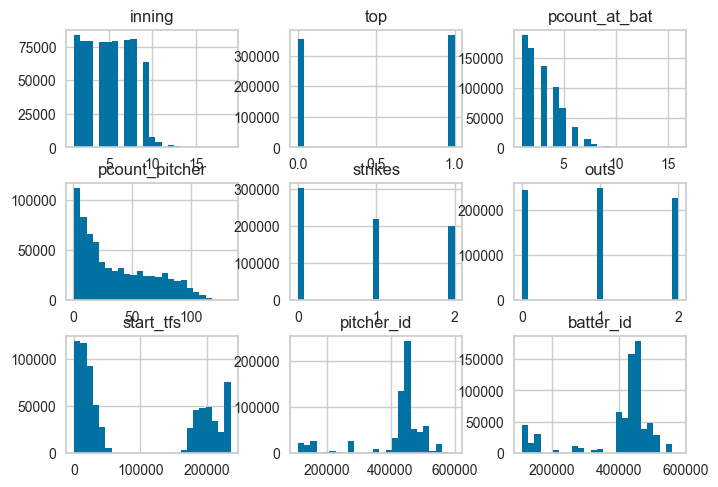

In [12]:
mlb_df.hist(bins=25)
# show the plot
plt.show()

## Check the existence of duplicate in the data

### Our data does not contain any duplicate

In [13]:
# Check for duplicates
duplicates = mlb_df.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()
num_duplicates

0

In [8]:
# Check for duplicates and display them
duplicates = mlb_df.duplicated(keep=False)
duplicate_rows = mlb_df[duplicates]

# Display the duplicate rows
print(duplicate_rows)


Empty DataFrame
Columns: [team_id_b, team_id_p, inning, top, at_bat_num, pcount_at_bat, pcount_pitcher, balls, strikes, fouls, outs, start_tfs, start_tfs_zulu, batter_id, stand, b_height, pitcher_id, p_throws, away_team_runs, home_team_runs, pitch_id, pitch_type]
Index: []


## Feature Engineering

In [7]:
import datetime
import time

def time_segmentation(df, col):
    time_value_lst = []
    for i in df[col]:
        if isinstance(i, str) and len(i.split()) > 1:
            x = time.strptime(i.split()[1], '%H:%M:%S')
            time_value_lst.append(datetime.timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds())
        else:
            time_value_lst.append(None)
    
    day_time_lst = []
    for time_val in time_value_lst:
        if time_val is None:
            day_time_lst.append('missing')
        elif 32400 <= time_val <= 39600:
            day_time_lst.append('morning')
        elif 39600 <= time_val <= 54000:
            day_time_lst.append('afternoon')    
        elif 54000 <= time_val < 64800:
            day_time_lst.append('primetime')
        elif 64800 <= time_val < 72000:
            day_time_lst.append('evening')    
        else:
            day_time_lst.append('other')
    
    return day_time_lst

mlb_df['time'] = time_segmentation(mlb_df, 'start_tfs_zulu')


In [7]:
mlb_df.time.value_counts()

other        594497
evening       94582
primetime     29882
Name: time, dtype: int64

In [8]:
# # Convert 'start_tfs_zulu' column to datetime

#drop the extra columns
mlb_df=mlb_df.drop('start_tfs_zulu', axis=1)

#drop the null values in pitch_type
mlb_df= mlb_df.dropna()

In [16]:
mlb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716681 entries, 26 to 718960
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   inning          716681 non-null  int64 
 1   top             716681 non-null  int64 
 2   pcount_at_bat   716681 non-null  int64 
 3   pcount_pitcher  716681 non-null  int64 
 4   strikes         716681 non-null  int64 
 5   outs            716681 non-null  int64 
 6   start_tfs       716681 non-null  int64 
 7   pitcher_id      716681 non-null  int64 
 8   stand           716681 non-null  object
 9   b_height        716681 non-null  object
 10  p_throws        716681 non-null  object
 11  batter_id       716681 non-null  int64 
 12  pitch_type      716681 non-null  object
 13  time            716681 non-null  object
dtypes: int64(9), object(5)
memory usage: 82.0+ MB


# Handle the imbalanced data class

In [18]:
mlb_df.pitch_type.value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

# Drop of pitch type = [UN, AB] as they have small insight and that will dilute the model

In [9]:
mlb_df= mlb_df[(mlb_df.pitch_type != 'UN') & (mlb_df.pitch_type != 'AB')]

# Using SMOTE

In [10]:
# Select the categorical features to encode
categorical_features = ['stand', 'b_height', 'p_throws', 'time']

# Split the dataset into features (X) and target variable (y)
X = mlb_df.drop('pitch_type', axis=1)
y = mlb_df['pitch_type']

# Encode the categorical features using OneHotEncoder
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(X[categorical_features])

# Split the encoded features and remaining numerical features
X_encoded = encoded_features.toarray()
X_remaining = X.drop(categorical_features, axis=1)

# Combine the encoded features with the remaining numerical features
X_combined = np.hstack((X_encoded, X_remaining))

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Determine the number of neighbors based on the minority class
n_samples = len(y_encoded)
n_minority = np.sum(y_encoded == np.min(y_encoded))
n_neighbors = min(n_minority - 1, 5)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='not majority', k_neighbors=n_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_combined, y_encoded)






In [12]:
classes_name= label_encoder.classes_
classes_name

array(['CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC',
       'KN', 'PO', 'SC', 'SI', 'SL'], dtype=object)

# Using StandardScaler with Random Forest Classifier

In [9]:
#  Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Create a StandardScaler instance
scaler = StandardScaler()

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [2],
    'classifier__max_features': ['auto'],
    'classifier__bootstrap': [True]
}

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', rf_classifier)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Transform the training and testing data using StandardScaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a RandomizedSearchCV instance
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=5)

# Fit the RandomizedSearchCV on your scaled training data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_


In [10]:
best_params

{'classifier__n_estimators': 100,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 5,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True}

In [11]:

y_train_pred = random_search.predict(X_train)
y_pred = random_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1-Score:', f1)

print('Train Accuracy:', train_accuracy)
print('Train Precision:', train_precision)
print('Train Recall:', train_recall)
print('Train F1-Score:', train_f1)

Test Accuracy: 0.07896146483019466
Test Precision: 0.009361602556353122
Test Recall: 0.07896146483019466
Test F1-Score: 0.016208138926663403
Train Accuracy: 0.07852337270268618
Train Precision: 0.009170030397072445
Train Recall: 0.07852337270268618
Train F1-Score: 0.016078843573918648


# Second try Using robust scaler and ExtratreesClassifier

## Scale the data

In [54]:
# Using RobustScaler
scaler = RobustScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

In [55]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3053324, 34)

(3053324,)

(763332, 34)

(763332,)

In [19]:

model = ExtraTreesClassifier(warm_start= True,n_estimators= 50, bootstrap= True, random_state= 66)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1-Score:', f1)

print('Train Accuracy:', train_accuracy)
print('Train Precision:', train_precision)
print('Train Recall:', train_recall)
print('Train F1-Score:', train_f1)


Test Accuracy: 0.8097118946932659
Test Precision: 0.8066913889096634
Test Recall: 0.8097118946932659
Test F1-Score: 0.806420624137989
Train Accuracy: 0.9999757641180562
Train Precision: 0.9999757641042925
Train Recall: 0.9999757641180562
Train F1-Score: 0.9999757638992289


# Save the model

In [21]:
import joblib

# Save the model to a file
filename = 'saved_model/extratreeclf.pkl'
joblib.dump(model, filename)

['saved_model/extratreeclf.pkl']

# Load the saved model and use on unseen data

In [56]:
import joblib

# Load the model from the file
filename = 'saved_model/extratreeclf.pkl'
loaded_model = joblib.load(filename)

pred= loaded_model.predict(X_test)
pred[0:10]

array([13,  8, 10, ...,  7,  2,  3])

In [59]:
classes_name

array(['CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC',
       'KN', 'PO', 'SC', 'SI', 'SL'], dtype=object)

In [39]:
unseen_data=X_test[1].reshape(1, -1)
pred=loaded_model.predict(unseen_data)
# Assuming label_encoder is your LabelEncoder object
y_pred_labels = label_encoder.inverse_transform(pred)
y_pred_labels

array(['FT'], dtype=object)

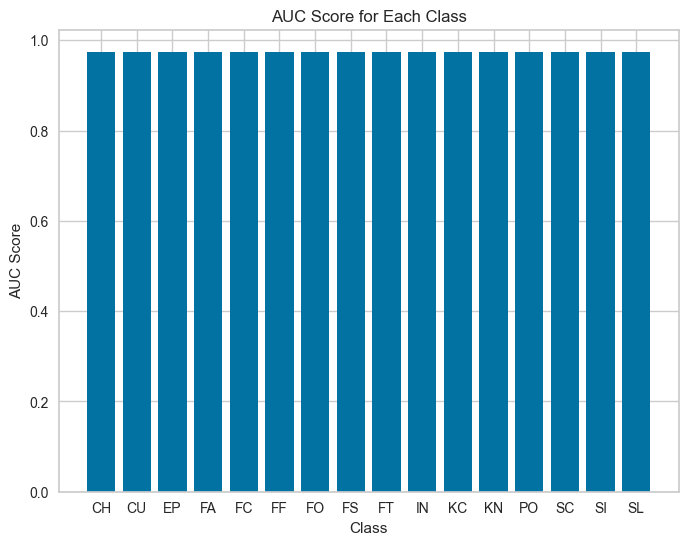

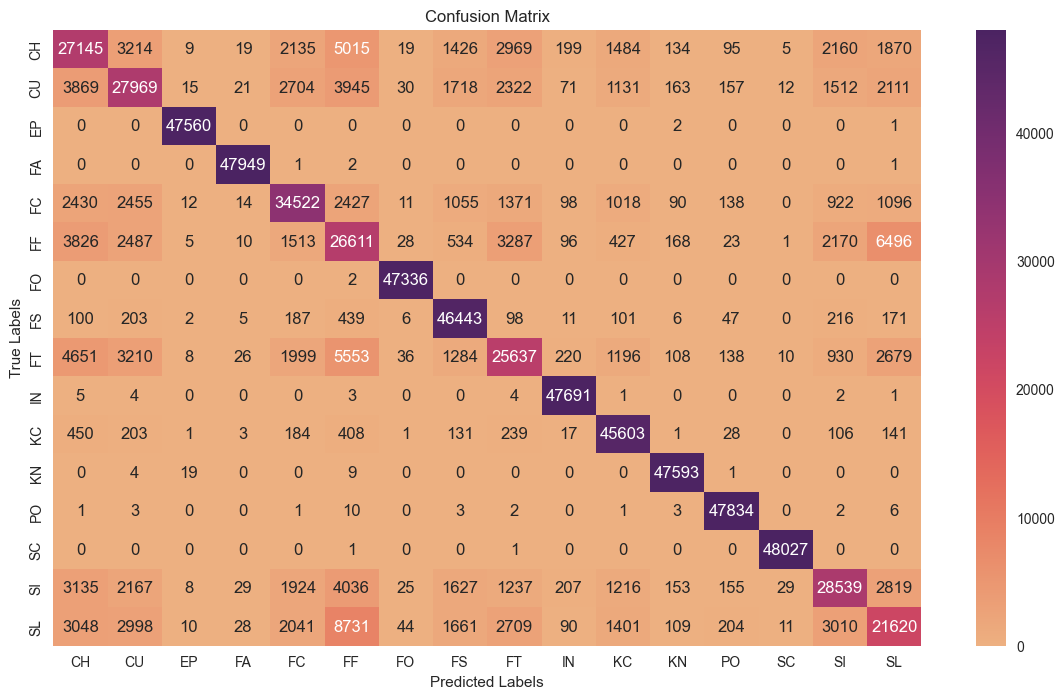

In [26]:
# Compute the predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Compute the AUC score for each class
auc_scores = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Plot the AUC scores
plt.figure(figsize=(8, 6))
plt.bar(classes_name, auc_scores)  # Use classes_name instead of range(len(auc_scores))
plt.xlabel('Class')
plt.ylabel('AUC Score')
plt.title('AUC Score for Each Class')
# plt.xticks(range(len(auc_scores)), classes_name)
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(14, 8))
sns.heatmap(cm, annot=True, cmap='flare', fmt='d', xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("images/confusion_matrix.jpg",  bbox_inches='tight')
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Assuming you have your model predictions in y_pred and the true labels in y_true
classification_report = classification_report(y_test, y_pred)
print(classification_report)


              precision    recall  f1-score   support

           0       0.56      0.57      0.56     47898
           1       0.62      0.59      0.60     47750
           2       1.00      1.00      1.00     47563
           3       1.00      1.00      1.00     47953
           4       0.73      0.72      0.73     47659
           5       0.47      0.56      0.51     47682
           6       1.00      1.00      1.00     47338
           7       0.83      0.97      0.89     48035
           8       0.64      0.54      0.59     47685
           9       0.98      1.00      0.99     47711
          10       0.85      0.96      0.90     47516
          11       0.98      1.00      0.99     47626
          12       0.98      1.00      0.99     47866
          13       1.00      1.00      1.00     48029
          14       0.72      0.60      0.66     47306
          15       0.55      0.45      0.50     47715

    accuracy                           0.81    763332
   macro avg       0.81   

<Figure size 800x600 with 0 Axes>

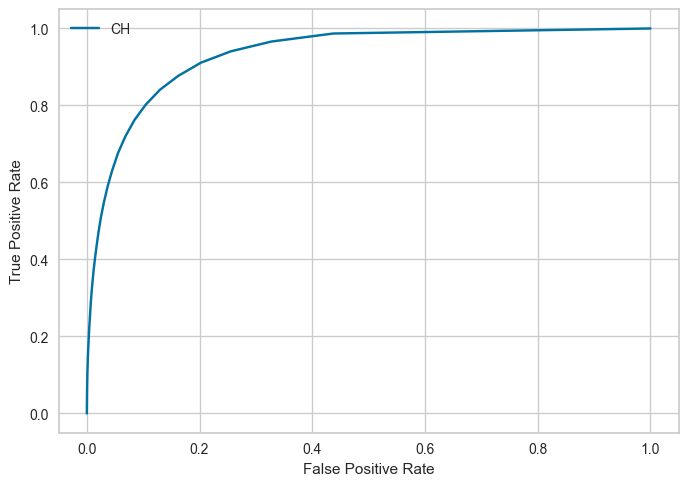

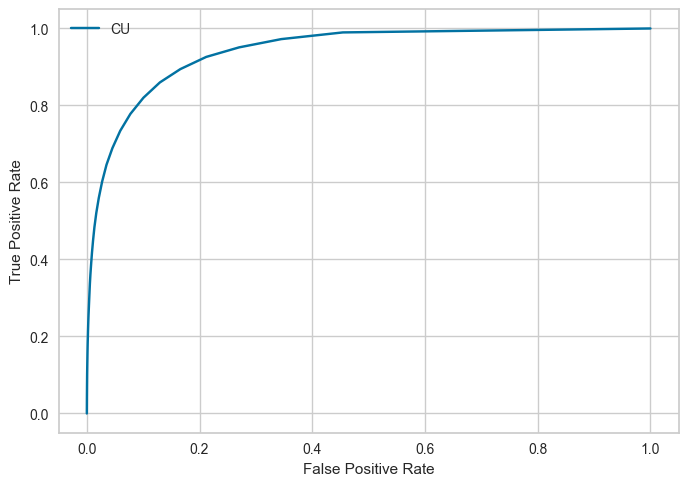

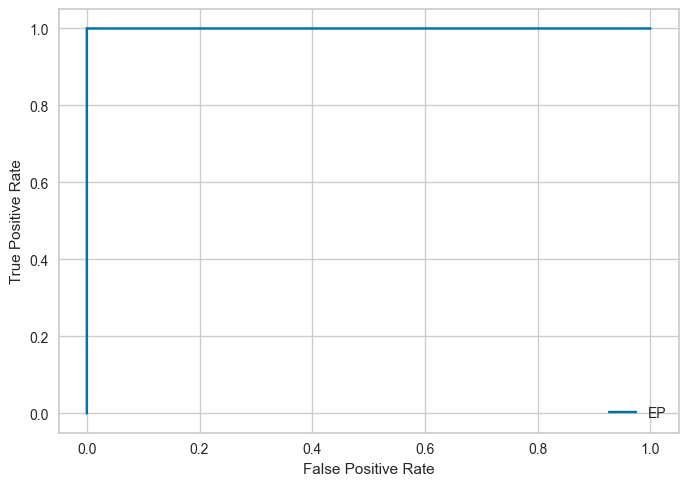

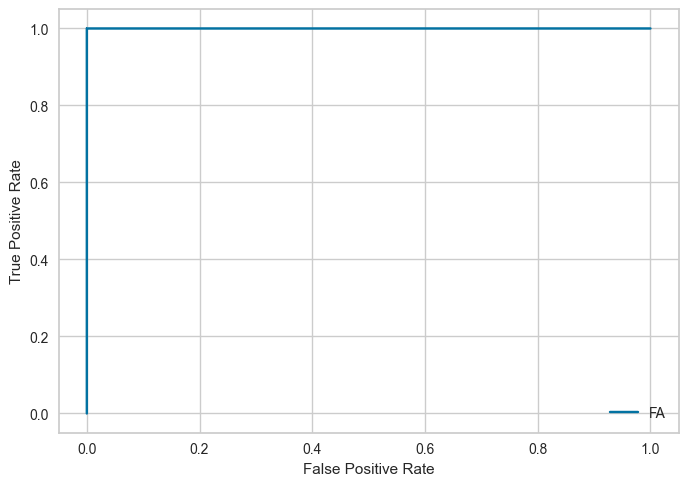

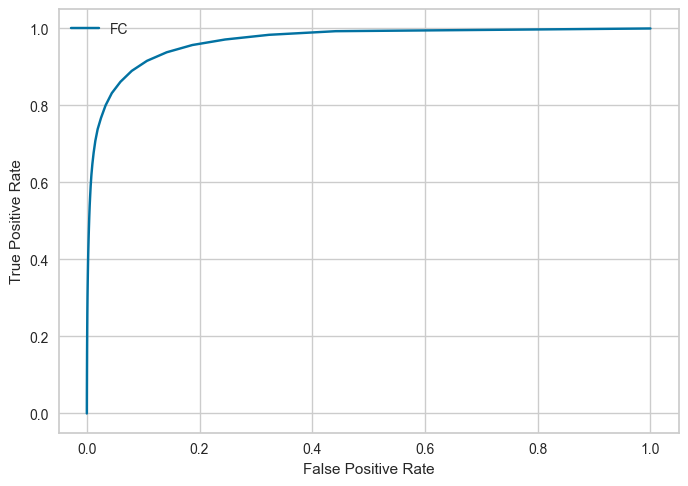

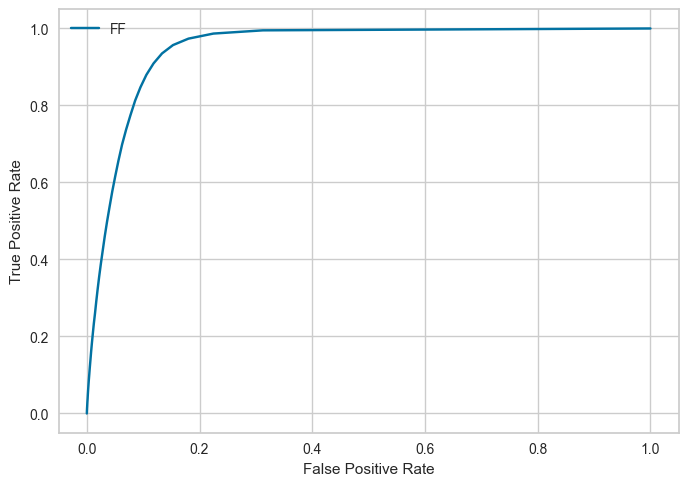

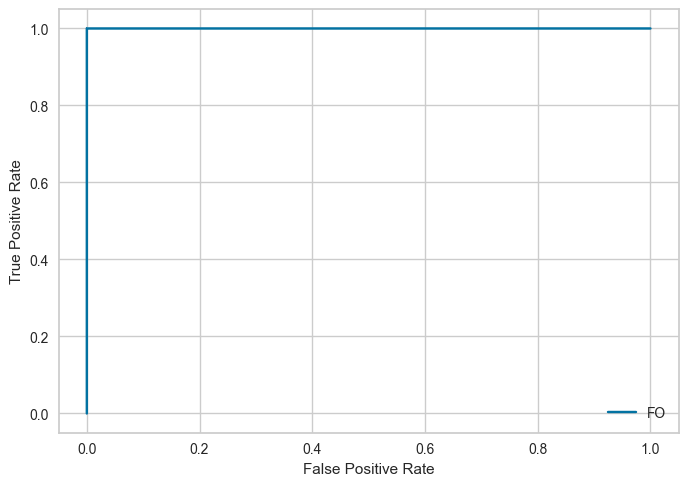

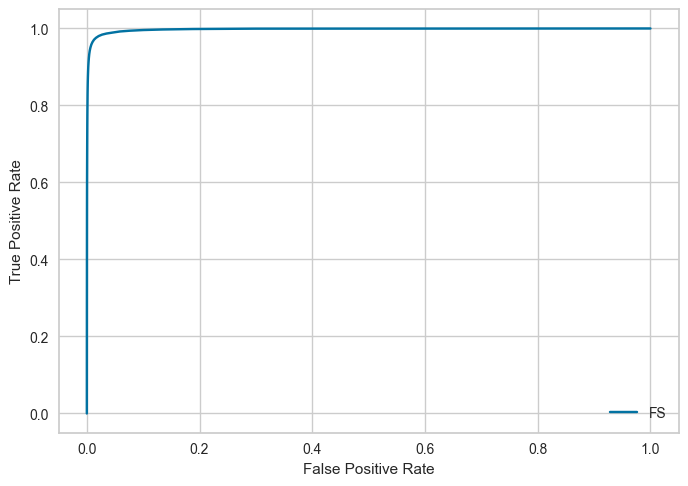

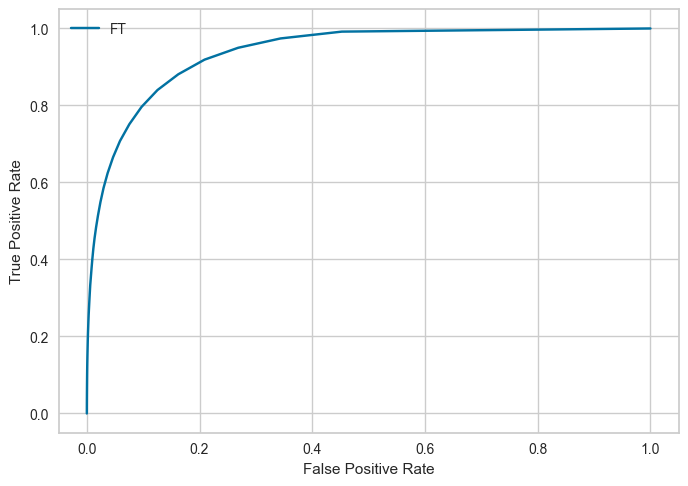

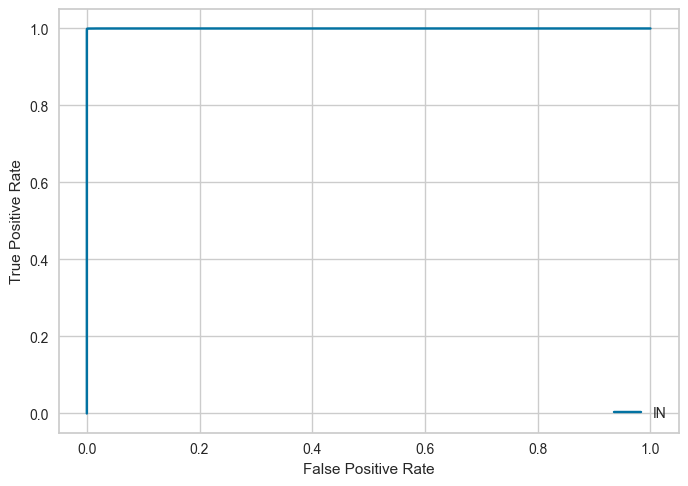

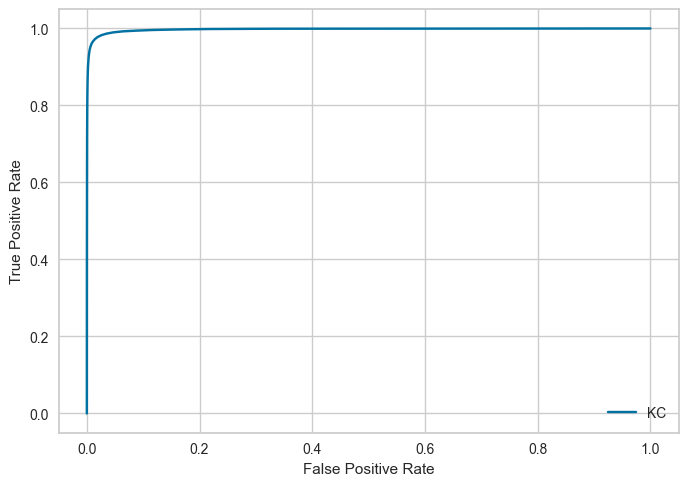

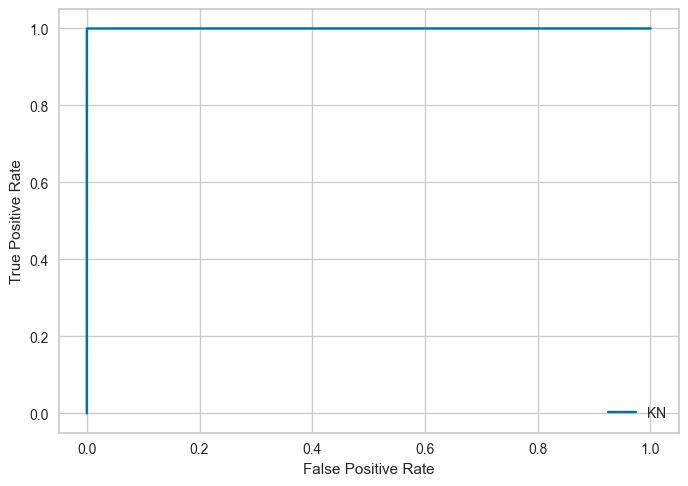

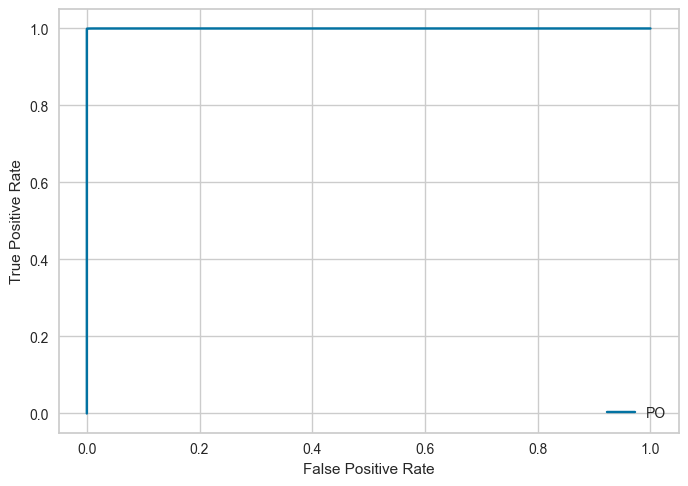

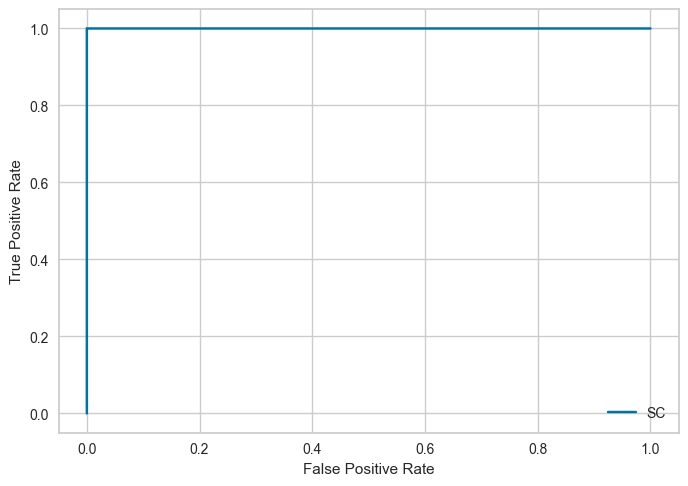

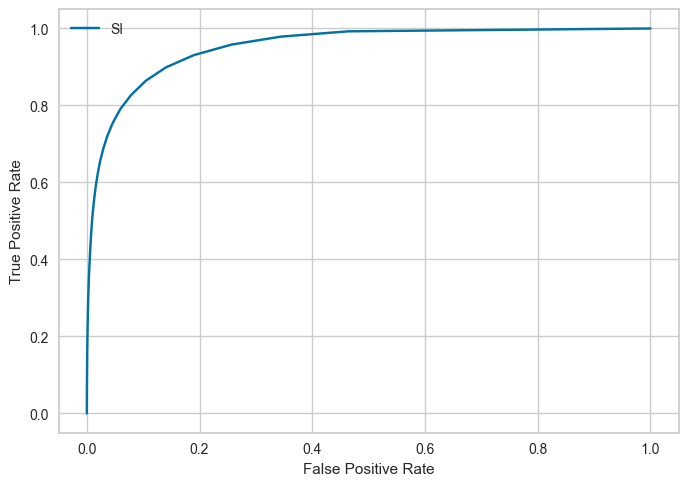

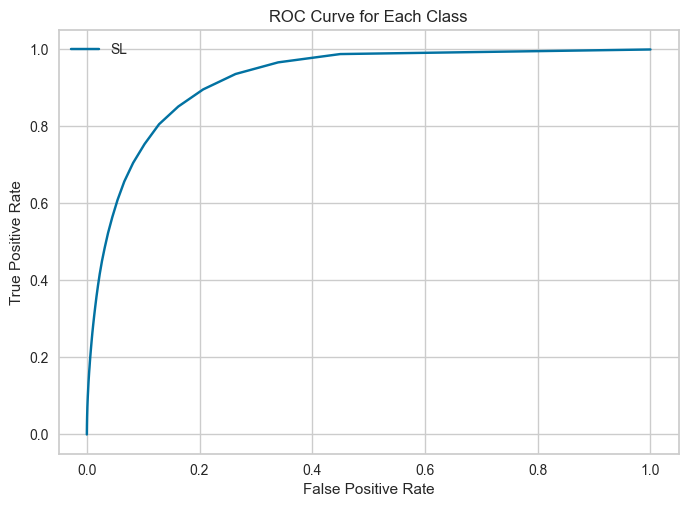

In [28]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Get the number of classes
num_classes = len(model.classes_)

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for class_index in range(num_classes):
    # Extract the predicted probabilities for the current class
    y_score = y_pred_prob[:, class_index]

    # Calculate the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=class_index)

    # Plot the ROC curve for the current class
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

    # Add a legend for the current class
    plt.legend([classes_name[class_index]])

# Set labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.show()


# Third Try to use Robust scaler + Randomized Search + Extratreesclassifier.. but my machine did not help and the run never ends

In [ ]:
extd_classifier = ExtraTreesClassifier()

# Create the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create a Randomized Search CV object
random_grid_extd = RandomizedSearchCV(
    estimator=extd_classifier,
    param_distributions=param_grid,
    n_jobs=4,
    cv=10,
    refit=True,
    return_train_score=True,
    random_state=66
)

random_grid_extd.fit(X_train, y_train)

y_test_pred = random_grid_extd.predict(X_test)
y_train_pred = random_grid_extd.predict(X_train)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1-Score:', f1)

print('Train Accuracy:', train_accuracy)
print('Train Precision:', train_precision)
print('Train Recall:', train_recall)
print('Train F1-Score:', train_f1)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred_prob contains the predicted probabilities for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# AutoMl 

In [31]:
automl=AutoML()

automl.settings = {
    'time_budget': 10,
    'metric': 'accuracy',
    'task': 'classification',
    'log_file_name': 'mlb_df.log'  # Update the log file name
}


automl.fit(X_train, y_train, **automl.settings)

[flaml.automl.logger: 07-07 15:10:28] {1693} INFO - task = classification
[flaml.automl.logger: 07-07 15:10:28] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-07 15:10:28] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-07 15:10:34] {1801} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 07-07 15:10:34] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-07 15:10:34] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-07 15:10:34] {2347} INFO - Estimated sufficient time budget=436129s. Estimated necessary time budget=10053s.
[flaml.automl.logger: 07-07 15:10:34] {2394} INFO -  at 6.2s,	estimator lgbm's best error=0.6560,	best estimator lgbm's best error=0.6560
[flaml.automl.logger: 07-07 15:10:34] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-07 15:10:34] {2394} INFO -  at 6.3s,	estimator lgbm's b

In [33]:
automl.best_estimator

'xgb_limitdepth'

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_test_predict = automl.predict(X_test)
y_train_predict = automl.predict(X_train)

# Calculate classification metrics for train set
accuracy_train = accuracy_score(y_train, y_train_predict)
precision_train = precision_score(y_train, y_train_predict, average='macro')
recall_train = recall_score(y_train, y_train_predict, average='macro')
f1_train = f1_score(y_train, y_train_predict, average='macro')

# Calculate classification metrics for test set
accuracy_test = accuracy_score(y_test, y_test_predict)
precision_test = precision_score(y_test, y_test_predict, average='macro')
recall_test = recall_score(y_test, y_test_predict, average='macro')
f1_test = f1_score(y_test, y_test_predict, average='macro')

print('Accuracy on train set:', accuracy_train)
print('Precision on train set:', precision_train)
print('Recall on train set:', recall_train)
print('F1-Score on train set:', f1_train)

print('Accuracy on test set:', accuracy_test)
print('Precision on test set:', precision_test)
print('Recall on test set:', recall_test)
print('F1-Score on test set:', f1_test)


Accuracy on train set: 0.6119416085551354
Precision on train set: 0.5963267490790054
Recall on train set: 0.6119598916344611
F1-Score on train set: 0.5900956241706146
Accuracy on test set: 0.6103412407707263
Precision on test set: 0.5942480996913426
Recall on test set: 0.6102673640748724
F1-Score on test set: 0.5882783895471013
